In [1]:
import torch 
import torch.nn as nn
from torchmetrics import R2Score
from torch.utils.data import Dataset, DataLoader

In [2]:
import pandas as pd 
import numpy as np 
from matplotlib import pyplot as plt

In [3]:
device = torch.device('mps')

In [4]:
link = './dataset/hoboken.csv'
data = pd.read_csv(link)
data.head()

,Date,Value
0,2015-01-31,2798.930748
1,2015-02-28,2824.110290
2,2015-03-31,2835.532496
3,2015-04-30,2844.208502
4,2015-05-31,2860.368254


In [5]:
test_size = 0.2
seqLength = 4

In [6]:
plotTrain, plotTest = data.iloc[:-int(data.shape[0] * test_size)] , data.iloc[-int(data.shape[0] * test_size):]
plotTrain.shape, plotTest.shape

((84, 2), (21, 2))

In [7]:
class MinMaxScaler:
    def __init__(self):
        self.max = None
        self.min = None
    
    def fit(self, x):
        self.max = x.max()
        self.min = x.min()
        
    def transform(self, x):
        x = (x-self.min) / (self.max - self.min)
        return x
    
    def fit_transform(self, x):
        self.fit(x)
        return self.transform(x)
    
    def inverse_transform(self, x):
        x = x * (self.max - self.min)
        x = x + self.min
        return x
    

In [8]:
class TimeSeriesDataset(Dataset): 
    def __init__(self, values, seqLength = 12):
        self.values = values.astype(np.float32)
        self.seqLength = seqLength
        
    def __getitem__(self, idx):
        x = self.values[idx:idx + self.seqLength]
        y = self.values[idx + self.seqLength]
        
        x = torch.tensor(x).to(device=device)
        y = torch.tensor(y).to(device=device)
        
        x = x.unsqueeze(-1)
        y = y.unsqueeze(-1)
        
        return x,y 
        
    def __len__(self):
        return len(self.values) - self.seqLength
    

In [9]:
# values is a numpy array 
def ready_dataset(values, test_size = 0.2, seqLength = 4): 
    
    values = values.to_numpy().astype(np.float32)
    # train test split 
    train, val = values[:int(-values.shape[0] * test_size)], values[int(-values.shape[0] * test_size):]
    scaler = MinMaxScaler()
    train = scaler.fit_transform(train)
    val = scaler.transform(val)
    trainset = TimeSeriesDataset(train, seqLength = seqLength)
    valset = TimeSeriesDataset(val, seqLength = seqLength)
    
    return trainset, valset, scaler
    

In [10]:
seqLength = 4
trainset, valset, hobokenscaler = ready_dataset(data.Value, test_size=test_size, seqLength = seqLength)

In [11]:
batch_size = 32
trainloader = DataLoader(trainset, batch_size=batch_size, shuffle=False)
valLoader = DataLoader(valset, batch_size= 10, shuffle=False)

In [12]:
class LSTM(nn.Module):
    def __init__(self, hidden_size = 10, num_layers = 1):
        super(LSTM, self).__init__()
        self.lstm = nn.LSTM(
            input_size= 1,
            hidden_size = hidden_size,
            num_layers = num_layers,
            batch_first=True,
        )
        self.fc = nn.Linear(hidden_size, 1)


    def forward(self, x):
        output, _ = self.lstm(x)
        output = output[:,-1, :]
        output = self.fc(output)
        return output

hoboken_model = LSTM().to(device = device)

In [13]:
lossfn = nn.MSELoss()
learning_rate = 0.01
opt = torch.optim.Adam(params=hoboken_model.parameters(), lr=learning_rate)

In [14]:
epochs = 120

for epoch in range(epochs):
    print('training time')
    running_loss = 0
    hoboken_model.train()
    for inputs, targets in trainloader:
        opt.zero_grad()

        # get output for LSTM 
        outputs = hoboken_model(inputs)

        # loss value
        loss = lossfn(outputs, targets)

        # running loss 
        running_loss += loss.item() / len(targets)

        # backpropogate 
        loss.backward()
        opt.step()


    print('Training done')
    print('Validation time')
    # validation 
    hoboken_model.eval()
    val_running_loss = 0
    
    # note down the validation predictions 
    ypred = torch.empty(size=(0,))
    ytest = torch.empty(size=(0,))
    
    for inputs, targets in valLoader:
        # get outputs
        outputs = hoboken_model(inputs)
        loss = lossfn(outputs, targets)
        
        # note validation loss
        val_running_loss = loss.item() / len(targets)

        ypred = torch.cat((ypred, outputs.cpu()), dim=0)
        ytest = torch.cat((ytest, targets.cpu()), dim=0)
        

    print(f'''epoch [{epoch+1}/{epochs}]
    \t training loss: {running_loss},
    \t validation loss: {val_running_loss},
    ''')


ypred = ypred.squeeze(-1).detach()
ytest = ytest.squeeze(-1)

training time
Training done
Validation time
epoch [1/120]
    	 training loss: 0.008867008902598172,
    	 validation loss: 0.49838859694344656,
    
training time
Training done
Validation time
epoch [2/120]
    	 training loss: 0.0065706386740203016,
    	 validation loss: 0.4428319590432303,
    
training time
Training done
Validation time
epoch [3/120]
    	 training loss: 0.006192596687469631,
    	 validation loss: 0.40353754588535856,
    
training time
Training done
Validation time
epoch [4/120]
    	 training loss: 0.006420167192118242,
    	 validation loss: 0.38563268525259836,
    
training time
Training done
Validation time
epoch [5/120]
    	 training loss: 0.006335337006021291,
    	 validation loss: 0.38153856141226633,
    
training time
Training done
Validation time
epoch [6/120]
    	 training loss: 0.0060075222863815725,
    	 validation loss: 0.38152054377964567,
    
training time
Training done
Validation time
epoch [7/120]
    	 training loss: 0.005710228520911187

In [15]:
# R2 score check 
r2score = R2Score().to(device=device)
r2score(ypred, ytest)

tensor(0.9630, device='mps:0')

In [16]:
ytest = hobokenscaler.inverse_transform(ytest)

In [17]:
ypred = hobokenscaler.inverse_transform(ypred)

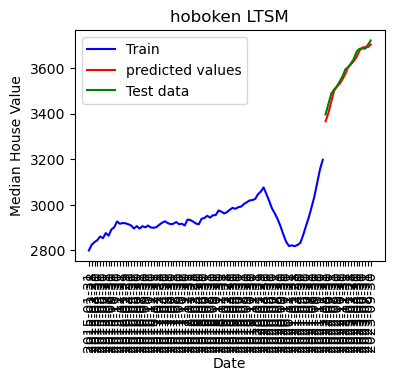

In [18]:
plt.figure(figsize=(4,3))
plt.title("hoboken LTSM")
plt.xlabel('Date')
plt.ylabel('Median House Value')
plt.xticks(rotation='vertical')
plt.plot(plotTrain.Date, plotTrain.Value, c='blue', label='Train')
plt.plot(plotTest.Date[seqLength:], ypred, c='red', label='predicted values')
plt.plot(plotTest.Date[seqLength:], ytest, c='green', label='Test data')
plt.legend()
plt.show()

In [19]:
torch.save(hoboken_model.state_dict(), './models/hoboken.pt')

# Loading model 

In [20]:
hoboken_model = LSTM().to(device=device)
hoboken_model.load_state_dict(torch.load('./models/hoboken.pt', weights_only=True))

<All keys matched successfully>

# New york

In [21]:
link = './dataset/new york.csv'
data = pd.read_csv(link)
data.head()

,index,Date,Value
0,0,2015-01-31,2786.750270
1,1,2015-02-28,2804.407379
2,2,2015-03-31,2817.752756
3,3,2015-04-30,2832.771956
4,4,2015-05-31,2839.597064


In [37]:
test_size = 0.2
plotTrain, plotTest = data.iloc[:-int(data.shape[0] * test_size)] , data.iloc[-int(data.shape[0] * test_size):]
plotTrain.shape, plotTest.shape

((84, 3), (21, 3))

In [38]:
seqLength = 4
trainset, valset, newyorkscaler = ready_dataset(data.Value, test_size=test_size, seqLength = seqLength)

In [46]:
batch_size = 32
trainloader = DataLoader(trainset, batch_size=batch_size, shuffle=False)
valLoader = DataLoader(valset, batch_size= 10, shuffle=False)

In [66]:
newyork_model = LSTM(hidden_size= 20, num_layers=2).to(device = device)

In [67]:
lossfn = nn.MSELoss()
learning_rate = 0.01
opt = torch.optim.Adam(params=newyork_model.parameters(), lr=learning_rate)

In [68]:
epochs = 100

for epoch in range(epochs):
    print('training time')
    running_loss = 0
    newyork_model.train()
    for inputs, targets in trainloader:
        opt.zero_grad()

        # get output for LSTM 
        outputs = newyork_model(inputs)

        # loss value
        loss = lossfn(outputs, targets)

        # running loss 
        running_loss += loss.item() / len(targets)

        # backpropogate 
        loss.backward()
        opt.step()


    print('Training done')
    print('Validation time')
    # validation 
    newyork_model.eval()
    val_running_loss = 0

    # note down the validation predictions 
    ypred = torch.empty(size=(0,))
    ytest = torch.empty(size=(0,))

    for inputs, targets in valLoader:
        # get outputs
        outputs = newyork_model(inputs)
        loss = lossfn(outputs, targets)

        # note validation loss
        val_running_loss = loss.item() / len(targets)

        ypred = torch.cat((ypred, outputs.cpu()), dim=0)
        ytest = torch.cat((ytest, targets.cpu()), dim=0)


    print(f'''epoch [{epoch+1}/{epochs}]
    \t training loss: {running_loss},
    \t validation loss: {val_running_loss},
    ''')


ypred = ypred.squeeze(-1).detach()
ytest = ytest.squeeze(-1)

training time
Training done
Validation time
epoch [1/100]
    	 training loss: 0.03440964315086603,
    	 validation loss: 0.33138748577662874,
    
training time
Training done
Validation time
epoch [2/100]
    	 training loss: 0.011630472261458635,
    	 validation loss: 0.14034034524645125,
    
training time
Training done
Validation time
epoch [3/100]
    	 training loss: 0.013284997316077352,
    	 validation loss: 0.16750987938472203,
    
training time
Training done
Validation time
epoch [4/100]
    	 training loss: 0.008803423319477588,
    	 validation loss: 0.23053194795336043,
    
training time
Training done
Validation time
epoch [5/100]
    	 training loss: 0.008989328554889653,
    	 validation loss: 0.24991985729762486,
    
training time
Training done
Validation time
epoch [6/100]
    	 training loss: 0.009166397903754842,
    	 validation loss: 0.23221829959324428,
    
training time
Training done
Validation time
epoch [7/100]
    	 training loss: 0.00820134364767,
    

In [69]:
# R2 score check 
r2score = R2Score().to(device=device)
r2score(ypred, ytest)

tensor(0.9142, device='mps:0')

In [70]:
ytest = newyorkscaler.inverse_transform(ytest)
ypred = newyorkscaler.inverse_transform(ypred)

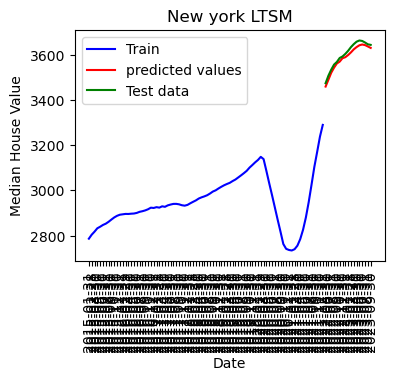

In [71]:
plt.figure(figsize=(4,3))
plt.title("New york LTSM")
plt.xlabel('Date')
plt.ylabel('Median House Value')
plt.xticks(rotation='vertical')
plt.plot(plotTrain.Date, plotTrain.Value, c='blue', label='Train')
plt.plot(plotTest.Date[seqLength:], ypred, c='red', label='predicted values')
plt.plot(plotTest.Date[seqLength:], ytest, c='green', label='Test data')
plt.legend()
plt.show()

In [72]:
torch.save(newyork_model.state_dict(), './models/newyork.pt')

# Philly

In [73]:
link = './dataset/philly.csv'
data = pd.read_csv(link)
data.head()

,Date,Value
0,2015-01-31,1250.824319
1,2015-02-28,1253.653977
2,2015-03-31,1263.257903
3,2015-04-30,1264.291265
4,2015-05-31,1270.390863


In [74]:
test_size = 0.2
plotTrain, plotTest = data.iloc[:-int(data.shape[0] * test_size)] , data.iloc[-int(data.shape[0] * test_size):]
plotTrain.shape, plotTest.shape

((84, 2), (21, 2))

In [75]:
seqLength = 4
trainset, valset, phillyscaler = ready_dataset(data.Value, test_size=test_size, seqLength = seqLength)

In [76]:
batch_size = 32
trainloader = DataLoader(trainset, batch_size=batch_size, shuffle=False)
valLoader = DataLoader(valset, batch_size= 10, shuffle=False)

In [77]:
philly_model = LSTM(hidden_size= 20, num_layers=2).to(device = device)

In [78]:
lossfn = nn.MSELoss()
learning_rate = 0.01
opt = torch.optim.Adam(params=philly_model.parameters(), lr=learning_rate)

In [79]:
epochs = 100

for epoch in range(epochs):
    print('training time')
    running_loss = 0
    philly_model.train()
    for inputs, targets in trainloader:
        opt.zero_grad()

        # get output for LSTM 
        outputs = philly_model(inputs)

        # loss value
        loss = lossfn(outputs, targets)

        # running loss 
        running_loss += loss.item() / len(targets)

        # backpropogate 
        loss.backward()
        opt.step()


    print('Training done')
    print('Validation time')
    # validation 
    philly_model.eval()
    val_running_loss = 0

    # note down the validation predictions 
    ypred = torch.empty(size=(0,))
    ytest = torch.empty(size=(0,))

    for inputs, targets in valLoader:
        # get outputs
        outputs = philly_model(inputs)
        loss = lossfn(outputs, targets)

        # note validation loss
        val_running_loss = loss.item() / len(targets)

        ypred = torch.cat((ypred, outputs.cpu()), dim=0)
        ytest = torch.cat((ytest, targets.cpu()), dim=0)


    print(f'''epoch [{epoch+1}/{epochs}]
    \t training loss: {running_loss},
    \t validation loss: {val_running_loss},
    ''')


ypred = ypred.squeeze(-1).detach()
ytest = ytest.squeeze(-1)

training time
Training done
Validation time
epoch [1/100]
    	 training loss: 0.04746685363352299,
    	 validation loss: 0.17239834581102645,
    
training time
Training done
Validation time
epoch [2/100]
    	 training loss: 0.014146742003504187,
    	 validation loss: 0.0768117904663086,
    
training time
Training done
Validation time
epoch [3/100]
    	 training loss: 0.00447057606652379,
    	 validation loss: 0.03442364079611642,
    
training time
Training done
Validation time
epoch [4/100]
    	 training loss: 0.009261954110115767,
    	 validation loss: 0.0441342294216156,
    
training time
Training done
Validation time
epoch [5/100]
    	 training loss: 0.009059363452252,
    	 validation loss: 0.06664995636258807,
    
training time
Training done
Validation time
epoch [6/100]
    	 training loss: 0.00933247827924788,
    	 validation loss: 0.08171049186161586,
    
training time
Training done
Validation time
epoch [7/100]
    	 training loss: 0.009636838920414448,
    	 v

In [80]:
# R2 score check 
r2score = R2Score().to(device=device)
r2score(ypred, ytest)

tensor(0.8611, device='mps:0')

In [81]:
ytest = phillyscaler.inverse_transform(ytest)
ypred = phillyscaler.inverse_transform(ypred)

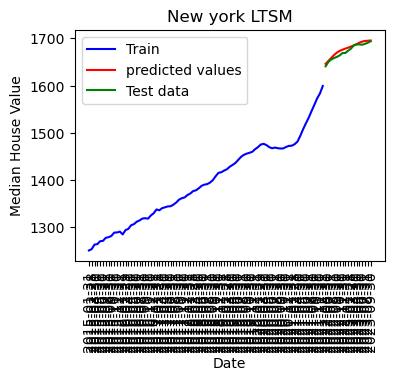

In [82]:
plt.figure(figsize=(4,3))
plt.title("New york LTSM")
plt.xlabel('Date')
plt.ylabel('Median House Value')
plt.xticks(rotation='vertical')
plt.plot(plotTrain.Date, plotTrain.Value, c='blue', label='Train')
plt.plot(plotTest.Date[seqLength:], ypred, c='red', label='predicted values')
plt.plot(plotTest.Date[seqLength:], ytest, c='green', label='Test data')
plt.legend()
plt.show()

In [84]:
torch.save(philly_model.state_dict(), './models/philly.pt')